In [1]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd

plt.style.use("ggplot")

In [2]:
# Connect to main PostGIS db
eng = nivapy.da.connect_postgis()

Connection successful.


In [3]:
# Connect to Critical Loads db
cl_eng = nivapy.da.connect_postgis(database="critical_loads")

Connection successful.


# CL Vestland: Process catchment data

## 1. Get catchments of interest

### 1.1. Outflow points

In [4]:
# Get outflows
sql = (
    "SELECT * FROM niva.stations "
    "WHERE station_id IN ( "
    "  SELECT station_id FROM niva.projects_stations "
    "  WHERE project_id IN ( "
    "    SELECT project_id FROM niva.projects "
    "    WHERE project_name = 'CL Vestland' "
    "    ) "
    "  ) "
)
stn_gdf = gpd.read_postgis(sql, eng)

# Reproject to ETRS89 UTM Z33N
stn_gdf = stn_gdf.to_crs("epsg:25833")

stn_gdf.head()

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
0,1260,Eks_Main,Eksingedal_Main,None,5.793674,60.728518,POINT (-1042.153 6767775.232)
1,1261,Eks_Opp,Eksingedal_Oppstr,None,5.905760,60.792344,POINT (6017.082 6773983.678)
2,1262,Eks_Side,Eksingedal_Side,None,5.806698,60.734305,POINT (-246.174 6768315.730)
3,1263,Gud_Main,Guddal_Main,None,5.345209,61.311320,POINT (-15742.579 6835715.827)
4,1264,Gud_Opp,Guddal_Oppstr,None,5.590573,61.229553,POINT (-4014.772 6824753.423)


### 1.2. Catchment boundaries

In [5]:
# Get catchments
stn_list = list(stn_gdf["station_id"].astype(str))
bind_pars = ",".join(stn_list)
sql = f"SELECT * FROM niva.catchments " f"WHERE station_id IN ({bind_pars})"
cat_gdf = gpd.read_postgis(sql, eng)

# Reproject to ETRS89 UTM Z33N
cat_gdf = cat_gdf.to_crs("epsg:25833")

# Calculate area
cat_gdf["area_km2"] = cat_gdf["geom"].area / 1e6

cat_gdf.head()

,station_id,geom,area_km2
0,1260,"MULTIPOLYGON (((3082.020 6765260.340, 3036.760...",255.688755
1,1261,"MULTIPOLYGON (((7265.790 6767632.250, 7240.550...",193.956874
2,1262,"MULTIPOLYGON (((6017.098 6773983.675, 5981.501...",39.101413
3,1263,"MULTIPOLYGON (((-15898.619 6835765.865, -15817...",263.187712
4,1264,"MULTIPOLYGON (((-1925.930 6823525.440, -1851.4...",94.099467


<AxesSubplot:>

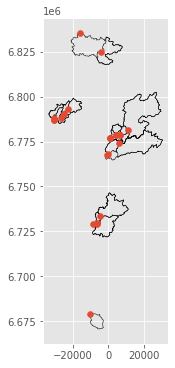

In [6]:
# Plot
ax = cat_gdf.plot(facecolor="none", edgecolor="k", figsize=(6, 6))
stn_gdf.plot(ax=ax)

## 2. Process AR50 and NVE lakes data

### 2.1. Extract data from database

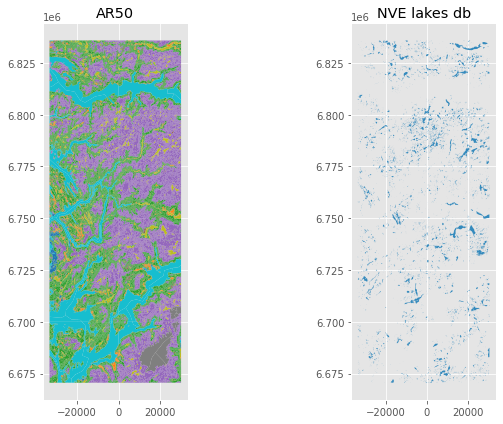

In [7]:
# Read AR50, clipping to catchment bounding box
ar50_gdf = nivapy.da.read_postgis(
    "physical",
    "norway_nibio_ar50_poly",
    eng,
    clip=cat_gdf,
)

# Read NVE lakes database, clipping to catchment bounding box
nve_gdf = nivapy.da.read_postgis(
    "physical",
    "norway_nve_innsjo_poly",
    eng,
    clip=cat_gdf,
)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].set_title("AR50")
axes[1].set_title("NVE lakes db")
ar50_gdf.plot("artype", ax=axes[0])
nve_gdf.plot(ax=axes[1])
plt.tight_layout()

### 2.2. Intersect with catchment boundaries

In [8]:
# AR50
ar50_gdf = gpd.overlay(ar50_gdf, cat_gdf, how="intersection")
ar50_gdf = ar50_gdf.dissolve(["station_id", "artype"]).reset_index()
ar50_gdf = ar50_gdf[["station_id", "artype", "description", "geometry"]]
ar50_gdf["area_km2"] = ar50_gdf["geometry"].area / 1e6

# Join station codes
ar50_gdf = ar50_gdf.merge(
    stn_gdf[["station_id", "station_code"]], how="left", on="station_id"
)

# Save
ar50_df = ar50_gdf[["station_id", "station_code", "artype", "description", "area_km2"]]
csv_path = r"../output/cl_vestland_ar50_summary.csv"
ar50_df.to_csv(csv_path, index=False)

# Show forest area
ar50_df.query("artype == '30'").head()

,station_id,station_code,artype,description,area_km2
2,1260,Eks_Main,30,Skog: Skogdekt areal,63.466174
8,1261,Eks_Opp,30,Skog: Skogdekt areal,36.474078
14,1262,Eks_Side,30,Skog: Skogdekt areal,19.599801
19,1263,Gud_Main,30,Skog: Skogdekt areal,120.057133
25,1264,Gud_Opp,30,Skog: Skogdekt areal,34.534787


<AxesSubplot:>

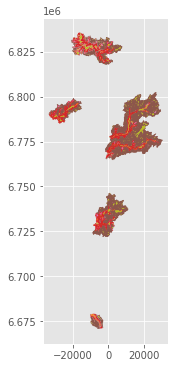

In [9]:
ar50_gdf.plot("artype", figsize=(6, 6))

In [10]:
# Lakes
nve_gdf = gpd.overlay(nve_gdf, cat_gdf, how="intersection")
nve_gdf = nve_gdf.dissolve(["station_id"]).reset_index()
nve_gdf = nve_gdf[["station_id", "geometry"]]
nve_gdf["area_km2"] = nve_gdf["geometry"].area / 1e6

# Join station codes
nve_gdf = nve_gdf.merge(
    stn_gdf[["station_id", "station_code"]], how="left", on="station_id"
)

# Save
nve_df = nve_gdf[["station_id", "station_code", "area_km2"]]
csv_path = r"../output/cl_vestland_nve_lakes_db_summary.csv"
nve_df.to_csv(csv_path, index=False)

nve_df.head()

,station_id,station_code,area_km2
0,1260,Eks_Main,5.902952
1,1261,Eks_Opp,5.021939
2,1262,Eks_Side,0.447632
3,1263,Gud_Main,19.980565
4,1264,Gud_Opp,5.999935


<AxesSubplot:>

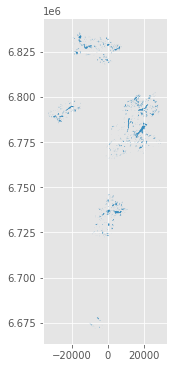

In [11]:
nve_gdf.plot(figsize=(6, 6))

## 3. Calculate Nupt

Nupt is calculated as an area-weighted average based on data for the BLR grid.

In [12]:
# Read BLR grid
sql = "SELECT * FROM deposition.dep_grid_blr"
blr_gdf = gpd.read_postgis(sql, cl_eng)

# Reproject to ETRS89 UTM Z33N
blr_gdf = blr_gdf.to_crs("epsg:25833")

# Get Nupt
sql = "SELECT * FROM water.blr_required_parameters WHERE parameter_id = 10"
nupt_df = pd.read_sql(sql, cl_eng)
nupt_df.rename(
    {"region_id": "cell_id", "value": "nupt_meqpm2pyr"}, axis="columns", inplace=True
)
del nupt_df["parameter_id"]

# Join
blr_gdf = blr_gdf.merge(nupt_df, how="left", on="cell_id")
blr_gdf.fillna(0, inplace=True)

# Intersect with BLR and calc area-weighted mean of Nupt
nupt_gdf = gpd.overlay(blr_gdf, cat_gdf, how="intersection")
nupt_gdf["area_prop"] = (nupt_gdf["geometry"].area / 1e6) / nupt_gdf["area_km2"]
nupt_gdf["nupt_meqpm2pyr"] = nupt_gdf["nupt_meqpm2pyr"] * nupt_gdf["area_prop"]
nupt_df = (
    nupt_gdf[["station_id", "area_prop", "nupt_meqpm2pyr"]]
    .groupby("station_id")
    .sum()
    .round(2)
    .reset_index()
)

# Join station codes
nupt_df = nupt_df.merge(
    stn_gdf[["station_id", "station_code"]], how="left", on="station_id"
)

# Save
nupt_df = nupt_df[["station_id", "station_code", "nupt_meqpm2pyr"]]
csv_path = r"../output/cl_vestland_nupt_summary.csv"
nupt_df.to_csv(csv_path, index=False)

nupt_df.head()

,station_id,station_code,nupt_meqpm2pyr
0,1260,Eks_Main,0.00
1,1261,Eks_Opp,0.00
2,1262,Eks_Side,0.00
3,1263,Gud_Main,0.99
4,1264,Gud_Opp,0.00
